# Segmentation-based approach for analysing CARTANA gene reads
<br>Author: Gabriel Emilio Herrera Oropeza <br>
Date: December 08th, 2021

### Import libraries

In [49]:
from cellpose import models, plot
import matplotlib.pyplot as plt
from tifffile import tifffile
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from skimage.measure import regionprops
from skimage import exposure, img_as_float
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import string

### Enter image path

In [2]:
# Modify the path to reference image as required
path2img = '/Volumes/emilio_passport/wellcome/rotations/spagnoli/data/DAPI/DAPI_50%_Sample1a_CARTANA2002901_20190702.tif'

### Define functions

In [3]:
def _cellpose(image, diameter = None, GPU = None):
 
    model = models.Cellpose(gpu = GPU, model_type = 'nuclei')
    channels = [0, 0]
    masks, flows, _, _ = model.eval(image, diameter = diameter, channels = channels, flow_threshold = 1, 
                                    cellprob_threshold=-6, 
                                    resample = True
                                   )

    return masks, flows


def genMaskImage(mask):
    y, x = mask.shape
    temp = np.ma.zeros((y, x, 3), dtype = 'uint8')
    for cell in tqdm(np.unique(mask)):
        r = random.randint(1, 255)
        g = random.randint(1, 255)
        b = random.randint(1, 255)
        if cell != 0:
            temp[mask == cell] = [r, g, b]
    masked = np.ma.masked_where(temp == 0, temp)
    return masked


def gammaCorrection(img, gamma = 0.25):

    image = img_as_float(img)
    gamma_corrected = exposure.adjust_gamma(image, gamma)
    
    return gamma_corrected

### Read image

Read image and perform gamma correction:

In [ ]:
image = tifffile.imread(path2img)
gamma_c = gammaCorrection(image, gamma = 0.25)

Enter pixel size:

In [6]:
um_per_pixel = 0.165 # Modify microns per pixel as required. Info given in CARTANA's README file.

Plot reference image and gamma corrected image:

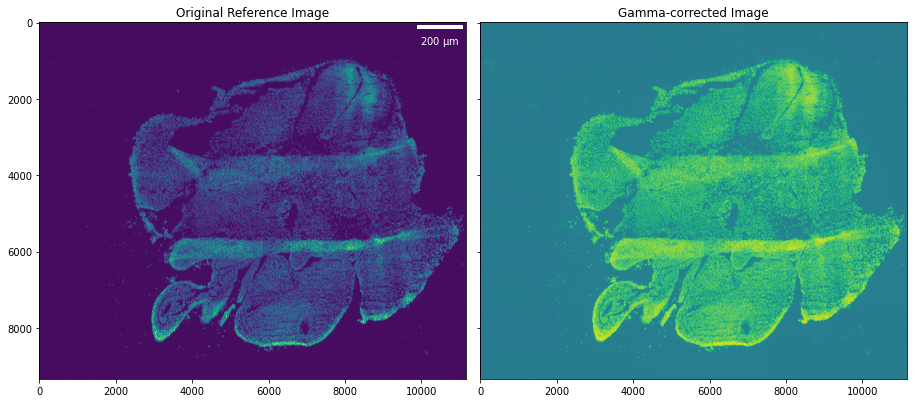

Image Shape: (9327, 11172)


In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6.4 * 2, 4.8 * 2), sharey = True)
ax = axes.ravel()

scalebar = ScaleBar(um_per_pixel, 'um', color="white", box_alpha=0.0)

print(f"Image Shape: {image.shape} pixels")
ax[0].imshow(image); ax[0].set_title("Original Reference Image"); ax[0].add_artist(scalebar)
ax[1].imshow(gamma_c); ax[1].set_title("Gamma-corrected Image")

plt.tight_layout()
plt.show()

Select region of interest:

In [17]:
# Modify as required
low_xlim = 5000
high_xlim = 7000
low_ylim = 5750
high_ylim = 7750

Verify correct selection of region of interest:

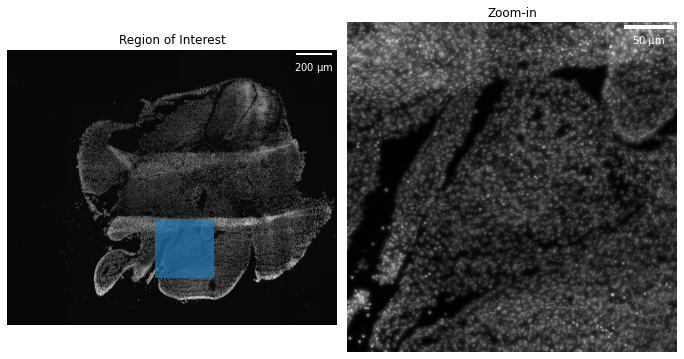

In [25]:
xy = np.array([[low_xlim, high_ylim],
               [high_xlim, high_ylim],
               [high_xlim, low_ylim],
               [low_xlim, low_ylim]])

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6.4*1.5, 4.8*1.5))
ax = axes.ravel()

scalebar1 = ScaleBar(um_per_pixel, 'um', color="white", box_alpha=0.0)
scalebar2 = ScaleBar(um_per_pixel, 'um', color="white", box_alpha=0.0)

patch = Polygon(xy, True)
p = PatchCollection([patch], alpha = 0.7)
ax[0].imshow(image, "gray"); ax[0].add_collection(p); ax[0].axis('off'); ax[0].set_title("Region of Interest"); ax[0].add_artist(scalebar1)
ax[1].imshow(image[low_ylim:high_ylim, low_xlim:high_xlim], "gray"); ax[1].axis('off'); ax[1].set_title("Zoom-in"); ax[1].add_artist(scalebar2)

plt.tight_layout()
plt.show()

Once a correct selection of the region of interest has been verified, we can proceed to confirm the selection:

In [26]:
wk_image = image[low_ylim:high_ylim, low_xlim:high_xlim]
wk_gcImage = gamma_c[low_ylim:high_ylim, low_xlim:high_xlim]

### Nuclei (DAPI) Segmentation and Mask Generation

In [27]:
mask, flow = _cellpose(wk_gcImage, diameter = 30, GPU = None)

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 128.24s; flow+mask computation 31.43
estimated masks for 1 image(s) in 160.49 sec
>>>> TOTAL TIME 160.50 sec


Save mask array:

In [ ]:
np.save("/Volumes/emilio_passport/wellcome/rotations/spagnoli/figures/exploration/whole_embryo/Sample2a_segmentation_gammaCorr_resample_masks.npy", 
         mask)

### Enter gene reads coordinates path

In [28]:
path2gc = "/Volumes/emilio_passport/wellcome/rotations/spagnoli/data/reads_Sample1a_LowThreshold_CARTANA2002901_20190702.csv"

### Read gene coordinates data

In [29]:
gene_coor = pd.read_csv(path2gc)

### Map gene expression to cells

In [30]:
scale_corr = 0.5 # Gene coordinates scale. Info given in CARTANA's README file.

Scale gene coordinates:

In [31]:
gene_coor["X_corr"] = [(row["X"] * scale_corr)-low_xlim for index, row in tqdm(gene_coor.iterrows(), total = gene_coor.shape[0])
                      ]
gene_coor["Y_corr"] = [(row["Y"] * scale_corr)-low_ylim for index, row in tqdm(gene_coor.iterrows(), total = gene_coor.shape[0])
                      ]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257333/257333 [00:18<00:00, 13951.07it/s]


Actually map gene reads to cells:

In [32]:
genes2cells = {}
for cell in tqdm(np.unique(mask)):
    if cell == 0:
        continue
    genes2cells[cell] = {}

for index, row in tqdm(gene_coor.iterrows(), total = gene_coor.shape[0]):
    x_pos = round(row["X_corr"])
    y_pos = round(row["Y_corr"])
    try:
        cell_no = mask[y_pos][x_pos]
    except:
        continue
    if cell_no != 0:
        if not row["gene"] in genes2cells[cell_no]:
            genes2cells[cell_no][row["gene"]] = 0
        genes2cells[cell_no][row["gene"]] += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257333/257333 [00:20<00:00, 12729.35it/s]


Convert dictionary to DataFrame:

In [48]:
out_df = pd.DataFrame.from_dict(data = genes2cells).T.reset_index()
out_df = out_df.rename(columns = {"index": "cell_no"})

Save DataFrame:

In [ ]:
out_df.to_csv("/Volumes/emilio_passport/wellcome/rotations/spagnoli/data/DAPI_50%_Sample1a_CARTANA2002901_20190702_lowThreshold_dapi2st_gammaCorr_resmaple_coloc.csv",
              index = False)


### Generate coloured image of the mask

In [33]:
clrd_img = genMaskImage(mask)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1933/1933 [00:18<00:00, 102.48it/s]


Get centroid pixel coordinates of each cell:

In [36]:
mask_data = {}
res_regionprops = regionprops(label_image = mask, intensity_image = wk_image)
for p in tqdm(res_regionprops):
    y_pos, x_pos = p['centroid']
    area = p["area"]
    mask_data[p["label"]] = {"x_pos": x_pos, "y_pos": y_pos, "area" : area}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1932/1932 [00:00<00:00, 14250.71it/s]


Plot masks over original image:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1933/1933 [00:00<00:00, 2436.48it/s]


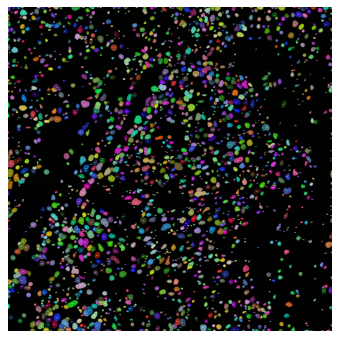

In [47]:
fig, ax = plt.subplots(figsize = (6.4, 4.8))
plt.imshow(image, "gray")
plt.imshow(clrd_img, alpha = 0.8)
for cell_no in tqdm(np.unique(mask)):
    if cell_no == 0:
        continue
    ax.text(mask_data[cell_no]["x_pos"], 
            mask_data[cell_no]["y_pos"], 
            cell_no,
            horizontalalignment = 'center',
            verticalalignment = "center",
            size = 1,
            color = 'w'
   )
plt.axis('off')
plt.tight_layout()
fig.savefig("/Volumes/emilio_passport/wellcome/rotations/spagnoli/figures/exploration/whole_embryo/Sample1a/Sample1a_segmentation_gammaCorr_resample.pdf", 
            dpi = 500)
plt.show()

### Generate gene expression heatmap plot

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.76s/it]


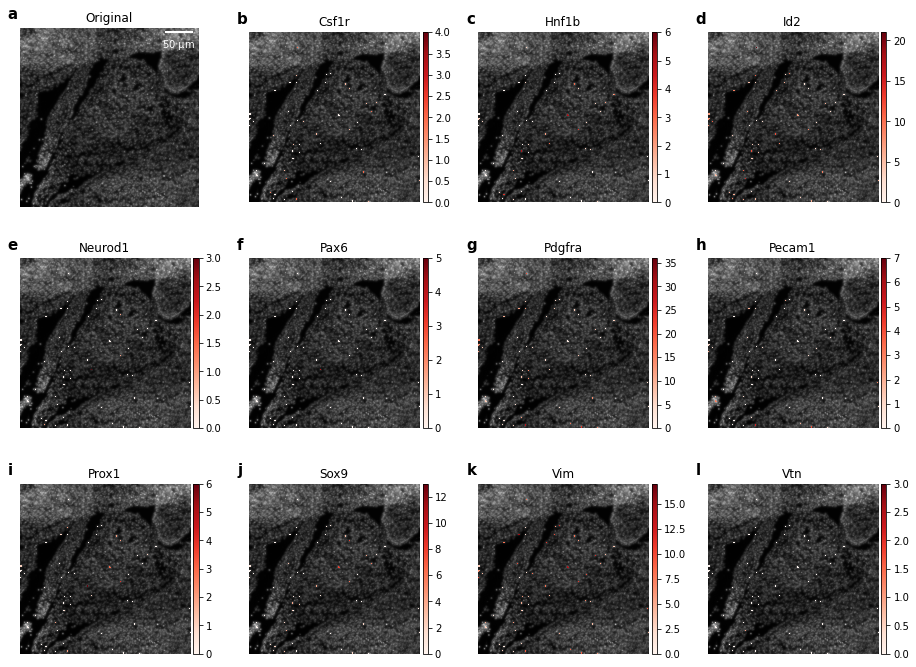

In [50]:
number_rows = 3 # Modify as required to show the total number of genes. Together with number of columns.
number_cols = 4 # Modify as required to show the total number of genes. Together with number of rows.

fig, axes = plt.subplots(ncols = number_cols, nrows = number_rows, figsize = (6.4 * 2, 4.8 * 2))
ax = axes.ravel()

ax[0].imshow(wk_image, "gray")
ax[0].set_title("Original")
ax[0].set_axis_off()
ax[0].text(-0.07, 1.05,
   string.ascii_lowercase[0],
   transform=ax[0].transAxes, 
   size=15, 
   weight='bold')
scalebar = ScaleBar(um_per_pixel, 'um', color="white",
        box_alpha=0.0) # 1 pixel = 1um
ax[0].add_artist(scalebar)

n = 1
for gene in tqdm(sorted(out_df.columns)):
    if gene != "cell_no":
        heatmap_mask = np.ma.zeros(mask.shape)
        for index, row in out_df.iterrows():
            if not np.isnan(row[gene]):
                heatmap_mask[mask == row["cell_no"]] = int(row[gene])
        heatmap_mask = np.ma.masked_where(mask == 0, heatmap_mask)
        divider = make_axes_locatable(ax[n])
        img = ax[n].imshow(wk_image, "gray")
        hmm = ax[n].imshow(heatmap_mask, cmap = "Reds")
        ax[n].set_axis_off()
        cax = divider.append_axes("right", size="3%", pad=0.05)
        fig.colorbar(hmm, cax = cax)
        ax[n].set_title(gene)
        ax[n].text(-0.07, 1.05,
           string.ascii_lowercase[n],
           transform=ax[n].transAxes, 
           size=15, 
           weight='bold')
        n += 1

plt.tight_layout()
fig.savefig(f"/Volumes/emilio_passport/wellcome/rotations/spagnoli/figures/exploration/whole_embryo/Sample1a/genes_heatmaps/Sample1a_lowTh_geneMerge_heatmap_Report.pdf", dpi=500)
plt.show()